# Land use regression

In [ ]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn import linear_model

import focalpy


def plot_da_and_gdf(da, gdf, column, *, ax=None, cmap="coolwarm", vmin=None, vmax=None):
    """Plot a raster data array and a geo-data frame with the same color scale."""
    if ax is None:
        _, ax = plt.subplots()
    if isinstance(column, str):
        column_data = gdf[column]
    else:
        column_data = column
    if vmin is None:
        vmin = min(da.min().item(), column_data.min())
    if vmax is None:
        vmax = max(da.max().item(), column_data.max())
    da.plot(ax=ax, alpha=0.7, vmin=vmin, vmax=vmax, cmap=cmap)
    gdf.plot(column_data, ax=ax, edgecolor="k", vmin=vmin, vmax=vmax, cmap=cmap)
    cx.add_basemap(ax, crs=gdf.crs)
    return ax

In [ ]:
study_area_filepath = "data/study-area.gpkg"
stations_filepath = "data/stations.gpkg"
netatmo_cws_filepath = "data/netatmo-cws.gpkg"

buildings_filepath = "data/buildings.gpkg"
tree_canopy_filepath = "data/tree-canopy.tif"
dem_filepath = "data/dem.tif"

ts_df_filepath = "data/heatwaves-2022.csv"

y_name = "$\Delta$T$_{mean}$"

grid_res = 1000

buffer_dists = [50, 100, 250, 500]

# viz
heatmap_kwargs = dict(annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
figwidth = plt.rcParams["figure.figsize"][0]
figheight = plt.rcParams["figure.figsize"][1]

<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3102665/1924100743.py:11: SyntaxWarning: invalid escape sequence '\D'
  y_name = "$\Delta$T$_{mean}$"


In [ ]:
ts_df = pd.read_csv(ts_df_filepath, index_col="time", parse_dates=["time"])
ts_df.head()

,530,534,2651,2652,2653,2655,2656,2657,2659,2679,...,2683,2688,2689,2695,2696,2697,2698,2810,REH,SMA
time,,,,,,,,,,,,,,,,,,,,,
2022-06-16 21:00:00,21.866667,25.090000,22.041667,24.926667,22.578333,23.745000,21.856667,22.213333,24.678333,23.503333,...,23.026667,22.785000,25.118333,24.286000,22.060000,20.572000,23.748333,21.160000,19.566667,21.716667
2022-06-17 21:00:00,21.320000,23.830000,21.565000,24.872000,19.938333,23.716667,22.910000,22.442500,23.753333,21.385000,...,22.215000,22.915000,24.925000,24.178333,21.976667,20.101667,24.010000,20.845000,18.566667,21.016667
2022-06-18 21:00:00,23.681667,26.655000,23.736667,27.240000,22.731667,25.928333,26.018333,24.455000,26.200000,23.633333,...,24.400000,24.760000,27.641667,26.760000,24.065000,22.815000,26.643333,23.256667,20.500000,23.400000
2022-06-19 21:00:00,27.363333,29.318333,27.553333,30.608333,26.130000,30.316667,25.961667,28.051667,29.436667,27.260000,...,28.218000,29.918333,30.813333,30.246667,29.603333,25.312000,30.326667,26.528333,26.533333,26.416667
2022-06-20 21:00:00,24.266000,24.626667,23.390000,25.152500,21.692500,24.483333,20.535000,24.211667,24.531667,23.700000,...,23.728333,24.143333,24.595000,24.936667,23.956667,23.872000,24.631667,23.793333,22.583333,22.100000


In [ ]:
ts_df.mean(axis="columns").head()

time
2022-06-16 21:00:00    23.072258
2022-06-17 21:00:00    22.514326
2022-06-18 21:00:00    24.929621
2022-06-19 21:00:00    28.454788
2022-06-20 21:00:00    23.884227
dtype: float64

In [ ]:
y_ser = ts_df.sub(ts_df.mean(axis="columns"), axis="index").mean().rename(y_name)
y_ser

530    -0.681919
534     1.287057
2651   -0.913134
2652    1.808307
2653   -2.162574
2655    1.190604
2656   -0.819991
2657   -0.385098
2659    1.196676
2679   -0.784157
2680    2.149188
2682    1.382390
2683   -0.247753
2688    0.517152
2689    1.917295
2695    1.539509
2696   -0.166777
2697   -2.031336
2698    1.485247
2810   -1.463562
REH    -3.262729
SMA    -1.554396
Name: $\Delta$T$_{mean}$, dtype: float64

In [ ]:
stations_gdf = gpd.read_file(stations_filepath).set_index("station_id")
# select only stations with valid temperature data
stations_gdf = stations_gdf.loc[y_ser.index]
stations_gdf.head()

,elevation,source,geometry
530,399.0,AWEL,POINT (2679316 1250429)
534,409.0,AWEL,POINT (2682450 1247990)
2651,454.0,AWEL,POINT (2680587 1252971)
2652,407.0,AWEL,POINT (2681246 1248514)
2653,604.0,AWEL,POINT (2687035 1245950)


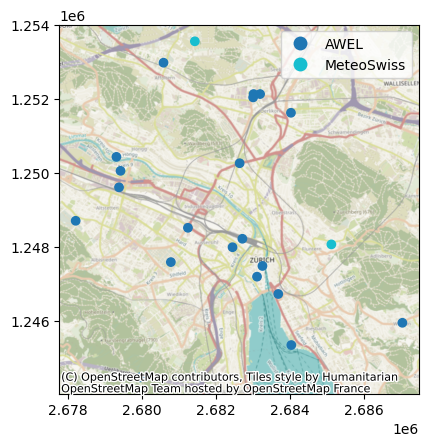

In [ ]:
ax = stations_gdf.plot(column="source", legend=True)
cx.add_basemap(ax, crs=stations_gdf.crs)

<>:7: SyntaxWarning: invalid escape sequence '\:'
<>:7: SyntaxWarning: invalid escape sequence '\:'
/tmp/ipykernel_3102665/1897662534.py:7: SyntaxWarning: invalid escape sequence '\:'
  legend_kwds={"label": f"{y_name} $\:$ [$\circ$C]"},


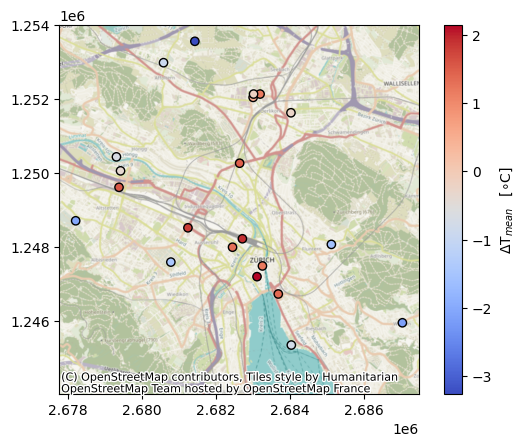

In [ ]:
# station_gdf.plot(ts_df.mean(), legend=True, cmap="coolwarm")
ax = stations_gdf.assign(**{y_name: y_ser}).plot(
    y_name,
    legend=True,
    cmap="coolwarm",
    edgecolor="k",
    legend_kwds={"label": f"{y_name} $\:$ [$\circ$C]"},
)
cx.add_basemap(ax, crs=stations_gdf.crs)

In [ ]:
building_gdf = gpd.read_file(buildings_filepath).set_index("id")
# add a "volume" column
building_gdf["volume"] = building_gdf["area"] * building_gdf["height"]
building_gdf.head()

,height,area,geometry,volume
id,,,,
4264,18.670619,10340.626863,"POLYGON ((2680693.885 1251498.715, 2680695.967...",193065.902368
4436,16.988255,5692.331205,"POLYGON ((2682125.575 1247611.584, 2682110.688...",96702.775194
4633,21.344529,3200.633956,"POLYGON ((2683816.74 1248231.125, 2683816.581 ...",68316.025064
7565,23.081217,3083.217221,"POLYGON ((2683434.771 1248110.727, 2683434.099...",71164.405863
57243,15.070181,1032.077993,"POLYGON ((2683508.7 1247190.211, 2683519.131 1...",15553.602132


In [ ]:
fa = focalpy.FocalAnalysis(
    [building_gdf, tree_canopy_filepath, dem_filepath],
    stations_gdf,
    buffer_dists,
    [
        "compute_vector_features",
        "compute_raster_features",
        "compute_terrain_attributes",
    ],
    feature_col_prefixes=["building", "tree", ""],
    feature_methods_args={
        "compute_vector_features": [{"volume": "sum"}],
        "compute_terrain_attributes": [["slope", "topographic_position_index"]],
    },
    feature_methods_kwargs={
        "compute_raster_features": {"stats": "sum"},
        "compute_terrain_attributes": {"stats": "mean"},
    },
)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Text(0.05, 0.9, '$R^2$ = 0.95')

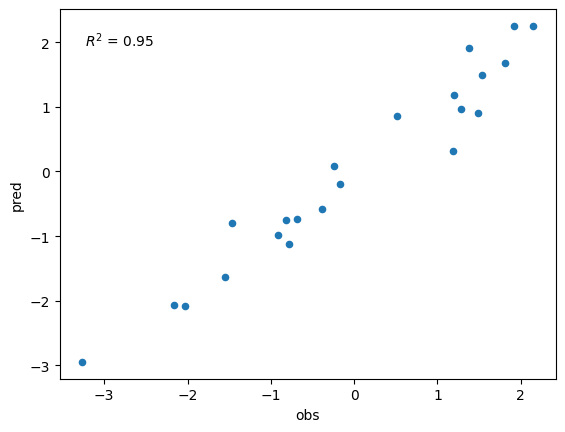

In [ ]:
X_df = fa.features_df  # .assign(elevation=stations_gdf["elevation"])
# rescale the features
# scaler = preprocessing.StandardScaler().fit(X_df)
# X_df = pd.DataFrame(
#     scaler.transform(X_df),
#     index=X_df.index,
#     columns=X_df.columns,
# )
# ensure that indices are aligned
X_df = X_df.loc[y_ser.index]
# data = pd.concat([y_ser, X_df], axis="columns")

model = linear_model.LinearRegression().fit(X_df, y_ser)
ax = pd.DataFrame({"obs": y_ser, "pred": model.predict(X_df)}).plot.scatter(
    x="obs", y="pred"
)
ax.annotate(
    f"$R^2$ = {model.score(X_df, y_ser):.2f}",
    xy=(0.05, 0.9),
    xycoords="axes fraction",
)

In [ ]:
results = sm.OLS(y_ser, sm.add_constant(X_df)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     $\Delta$T$_{mean}$   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     5.735
Date:                Wed, 26 Nov 2025   Prob (F-statistic):             0.0317
Time:                        15:25:10   Log-Likelihood:                -7.5805
No. Observations:                  22   AIC:                             49.16
Df Residuals:                       5   BIC:                             67.71
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [ ]:
focalpy.scale_eval_ser(X_df, y_ser, how="individual")

building_volume_sum              building_volume_sum_50                 0.284406
                                 building_volume_sum_100                0.315045
                                 building_volume_sum_250                0.503243
                                 building_volume_sum_500                0.571616
slope_mean                       slope_mean_50                          0.057369
                                 slope_mean_100                         0.021732
                                 slope_mean_250                         0.023251
                                 slope_mean_500                         0.038490
topographic_position_index_mean  topographic_position_index_mean_50     0.002017
                                 topographic_position_index_mean_100    0.109190
                                 topographic_position_index_mean_250    0.101497
                                 topographic_position_index_mean_500    0.013587
tree_sum                    

In [ ]:
soe_features = focalpy.scale_of_effect_features(X_df, y_ser, how="individual")
soe_features

array(['building_volume_sum_500', 'slope_mean_50',
       'topographic_position_index_mean_100', 'tree_sum_100'],
      dtype=object)

In [ ]:
results = sm.OLS(y_ser, sm.add_constant(X_df[soe_features])).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     $\Delta$T$_{mean}$   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     7.570
Date:                Wed, 26 Nov 2025   Prob (F-statistic):            0.00108
Time:                        15:25:31   Log-Likelihood:                -28.919
No. Observations:                  22   AIC:                             67.84
Df Residuals:                      17   BIC:                             73.29
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

<Axes: xlabel='x', ylabel='y'>

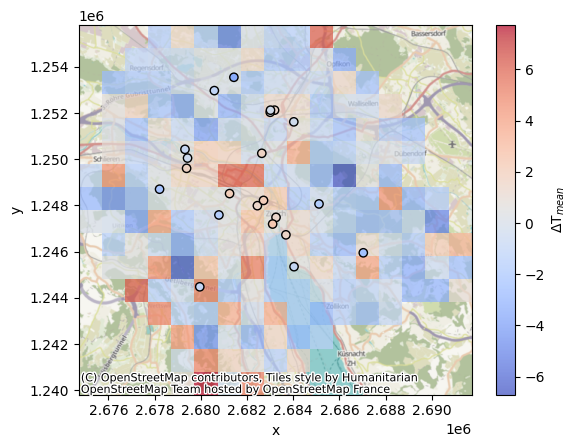

In [ ]:
pred_da = fa.predict_raster(model, study_area_filepath, grid_res, pred_label=y_name)
# plot the raster
plot_da_and_gdf(pred_da, stations_gdf, y_ser)